## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
import zipfile
import tarfile

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

from scipy.ndimage import gaussian_filter1d

sys.path.append('../data/EGTEA/Gaze_Data/gaze_data')
from gaze_io_sample import parse_gtea_gaze

from phosphene.uniformity import DynamicAmplitudeNormalizer
from components.modulated_conv2d import ModulatedConv2d, UnifiedInputModulation
from phosphene.density import VisualFieldMapper

import math

# GTEA Gaze+ Dataset
EGTEA Gaze+ is by far **the largest and most comprehensive** dataset for First Person Vision (**FPV**), with an emphasis on FPV action recognition and gaze estimation. The dataset comes with first person videos, gaze tracking data, densely annotated action labels and sparsely annotated hand masks. 

In [2]:
# # Define the root directory where all the zips are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract zip files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".zip"):
#             zip_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the zip file
            
#             print(f"Extracting {zip_path} to {extract_to}...")
#             with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                 zip_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

# # Define the root directory where all the tar files are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract tar files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".tar"):  # Check for tar files
#             tar_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the tar file
            
#             print(f"Extracting {tar_path} to {extract_to}...")
#             with tarfile.open(tar_path, 'r') as tar_ref:
#                 tar_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

In [3]:
file_name = "OP01-R01-PastaSalad"

# Path to the gaze data file
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
gaze_data = parse_gtea_gaze(gaze_data_path)
gaze_data.shape

# Path to the video file
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"

Frame 50: Gaze Point (0.57, 0.56), Gaze Type: 1


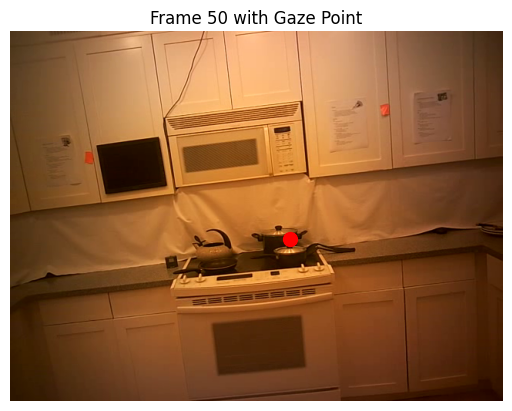

In [4]:
# Index of the frame to analyze
frame_i = 50

# Open the video
cap = cv2.VideoCapture(video_path)

# Get the gaze data for the specific frame
gaze_point = gaze_data[frame_i, :]

if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
    print(f"Frame {frame_i}: Gaze point out of bounds.")
else:
    gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates
    gaze_type = int(gaze_point[2])
    print(f"Frame {frame_i}: Gaze Point ({gaze_x:.2f}, {gaze_y:.2f}), Gaze Type: {gaze_type}")

# Set the video to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
ret, frame = cap.read()

if ret:
    # Denormalize gaze coordinates to image resolution
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    gaze_x_px = int(gaze_point[0] * frame_width)
    gaze_y_px = int(gaze_point[1] * frame_height)

    # # Overlay the gaze point on the frame
    # cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    # Display the frame with Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # overlay the gaze point
    plt.scatter(gaze_x_px, gaze_y_px, color='red', s=100)
    plt.title(f"Frame {frame_i} with Gaze Point")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

cap.release()

256
(256, 256, 3)


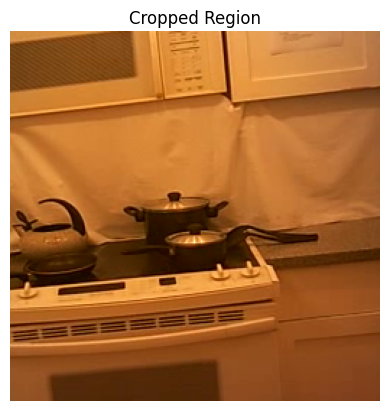

In [5]:
def crop_frame(frame, gaze_x, gaze_y, crop_size, resize=None):
    h, w, _ = frame.shape
    x_center = int(gaze_x * w)
    y_center = int(gaze_y * h)

    # Calculate desired crop boundaries (might be outside frame)
    desired_x1 = x_center - crop_size // 2
    desired_y1 = y_center - crop_size // 2
    desired_x2 = desired_x1 + crop_size
    desired_y2 = desired_y1 + crop_size

    # Calculate how much we're out of bounds on each side
    pad_left = max(0, -desired_x1)
    pad_right = max(0, desired_x2 - w)
    pad_top = max(0, -desired_y1)
    pad_bottom = max(0, desired_y2 - h)

    # Clamp coordinates to actual frame dimensions
    x1 = max(0, desired_x1)
    y1 = max(0, desired_y1)
    x2 = min(w, desired_x2)
    y2 = min(h, desired_y2)

    # Perform the actual crop
    cropped_frame = frame[y1:y2, x1:x2]

    # Apply asymmetric padding only where needed
    if pad_left + pad_right + pad_top + pad_bottom > 0:
        cropped_frame = cv2.copyMakeBorder(
            cropped_frame,
            pad_top, pad_bottom,
            pad_left, pad_right,
            cv2.BORDER_REFLECT
        )

    # Final resize if requested
    if resize and resize != crop_size:
        cropped_frame = cv2.resize(cropped_frame, (resize, resize))

    return cropped_frame

# Define the frame resolution and crop size
camera_fov = 40 # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 16

ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)
print(crop_size)

if ret:
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    print(cropped.shape)

    # Display the cropped region
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Region")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

# Simulator

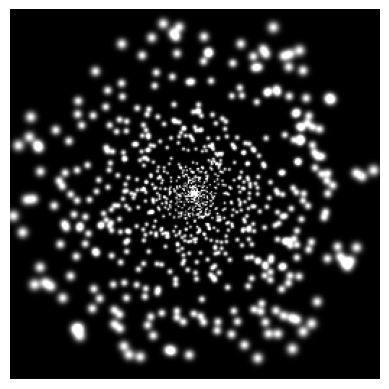

In [6]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')
params['run']['resolution'] = [crop_size, crop_size]

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

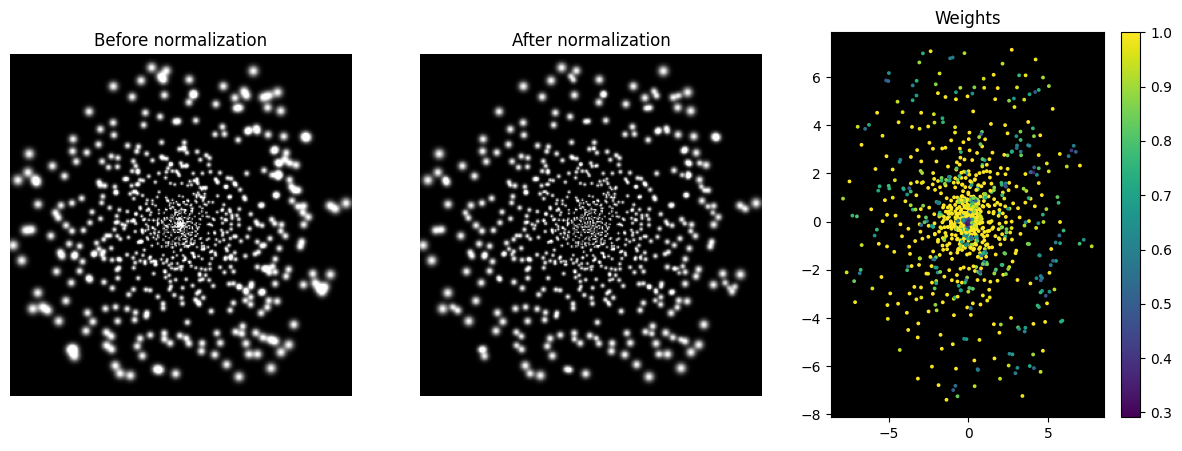

In [7]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=1,
    scale=0.5,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    steps=50,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init)
stim_weights = normalizer.weights

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# Fov Conv2D LoG Module

In [8]:
def modified_cdf_normalization(electrode, amplitude):
    # electrode: a tensor of stimulation values.
    # Compute mean and std on the nonzero elements if desired,
    # or use global mean/std if that makes sense in your application.
    # Here, for example, we compute over all values:
    mean_val = electrode.mean()
    std_val = electrode.std()
    
    # Compute the standard normal CDF at a value:
    def standard_normal_cdf(x):
        return 0.5 * (1 + torch.erf(x / math.sqrt(2)))
    
    # Compute CDF at zero:
    cdf0 = standard_normal_cdf((0 - mean_val) / std_val)
    
    # Create a normalized tensor, preserving zeros:
    # For nonzero elements, apply the mapping.
    normalized = electrode.clone()
    # Create a mask for nonzero entries:
    mask = electrode > 0
    # For these entries, compute their z-scores:
    z = (electrode[mask] - mean_val) / std_val
    cdfx = standard_normal_cdf(z)
    
    # Map the nonzero elements so that when x==0, the output is 0,
    # and as x increases, F(x) approaches amplitude.
    normalized[mask] = amplitude * (cdfx - cdf0) / (1 - cdf0)
    # (Elements that are zero remain zero.)
    return normalized

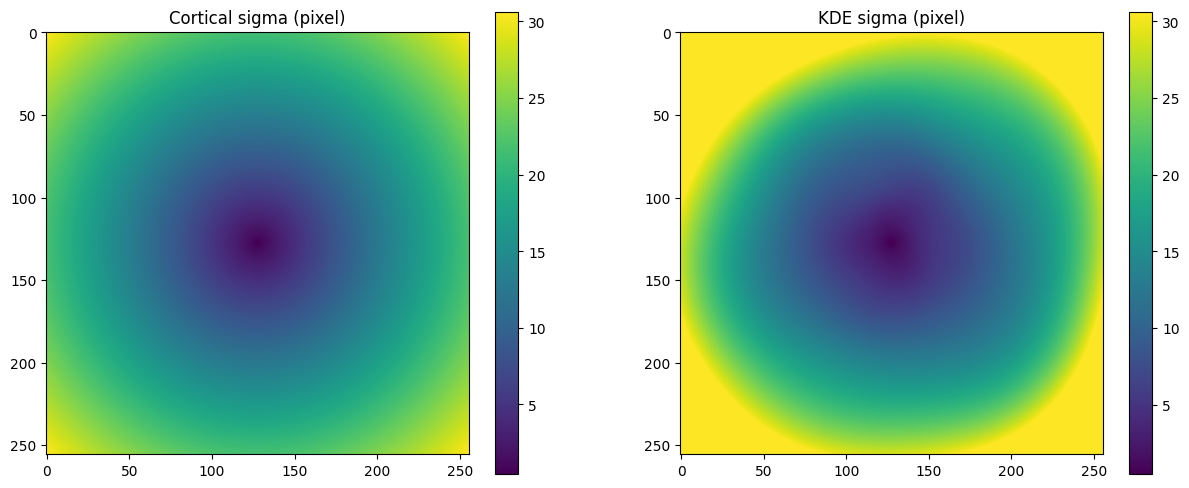

In [9]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=32, alpha=1.0, total_phosphenes=1024)
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

# plot sigma_cortical_pix, sigma_kde_pix

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

In [10]:
sigma_map_tensor = torch.Tensor(sigma_cortical_pix).float().cuda().unsqueeze(0).unsqueeze(0).detach()
layer = UnifiedInputModulation(
    kernel_size=127,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

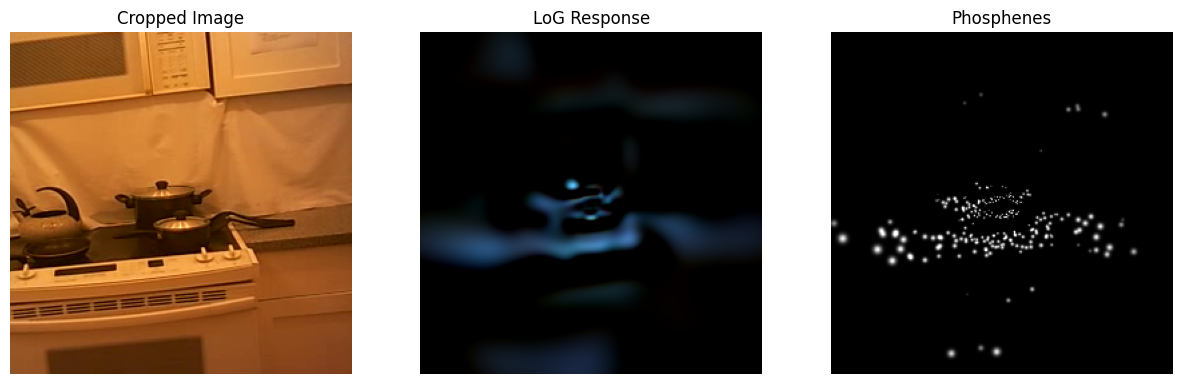

In [11]:
# BGR to RGB
image = cropped[..., ::-1] / 255

image_tensor = torch.Tensor(image.transpose(2,0,1)).unsqueeze(0).float().cuda().detach()

with torch.no_grad():
    response = layer(image_tensor).clip(0, None).detach()
response = (response - response.min()) / (response.max() - response.min())
response = response.squeeze().cpu().detach().numpy()

simulator.reset()
stimulus = torch.tensor(response.max(0)).float().cuda()
electrodes = simulator.sample_stimulus(stimulus, rescale=True)
electrodes = modified_cdf_normalization(electrodes, amplitude)
phosphenes = simulator(electrodes*stim_weights) 

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Cropped Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(response.transpose(1,2,0)[:, :, ::-1], cmap='gray')
plt.title('LoG Response')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.title('Phosphenes')
plt.axis('off')

plt.show()

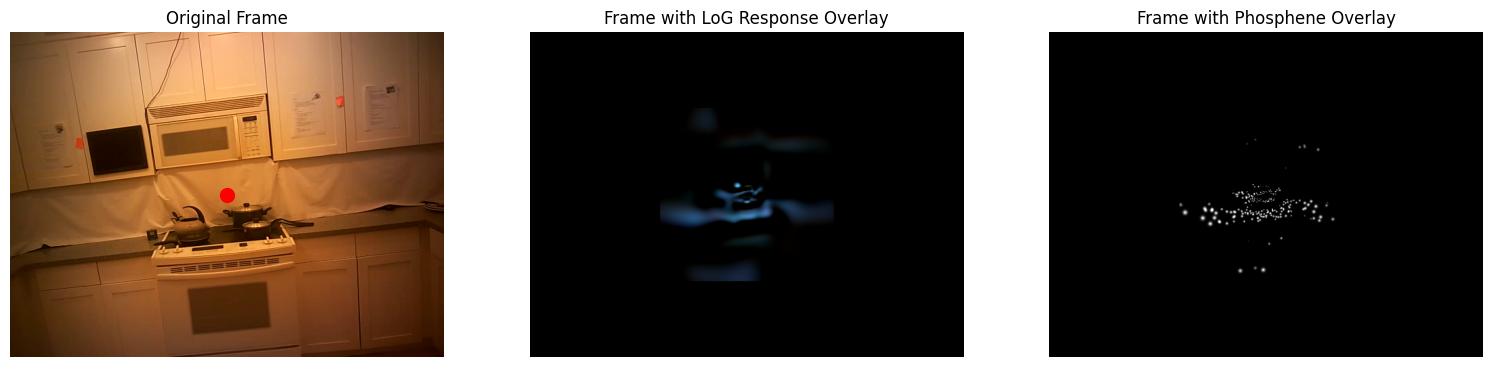

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def overlay_image(original_frame, overlay_image, gaze_x, gaze_y, fov_camera=90, fov_overlay=16):
    """
    Overlay an overlay image (which may be grayscale or RGB) onto the original frame,
    based on a normalized gaze coordinate. The overlay is placed in a region computed from
    the overlay image size. Optionally, the overlay image could be resized based on the ratio 
    fov_overlay/fov_camera.
    
    Parameters
    ----------
    original_frame : np.ndarray
        The original frame (can be grayscale [H, W] or RGB [H, W, 3]).
    overlay_image : np.ndarray
        The overlay image (grayscale [H, W] or RGB [H, W, 3]).
    gaze_x : float
        Normalized gaze x-coordinate (0 to 1).
    gaze_y : float
        Normalized gaze y-coordinate (0 to 1).
    fov_camera : float, optional
        Field of view of the camera in degrees (default 90).
    fov_overlay : float, optional
        Field of view of the overlay image in degrees (default 16).
    
    Returns
    -------
    combined_image : np.ndarray
        The original image with the overlay image overlaid.
    """
    # Get original frame dimensions.
    frame_height, frame_width = original_frame.shape[:2]
    # Use a copy of the original frame for the overlay.
    combined_image = np.zeros_like(original_frame)
    
    # Compute the center of the gaze in pixel coordinates.
    x_center = int(gaze_x * frame_width)
    y_center = int(gaze_y * frame_height)
    
    # Get overlay image dimensions.
    overlay_h, overlay_w = overlay_image.shape[:2]
    
    # Optionally: You might want to resize the overlay_image proportionally based on fov_overlay/fov_camera.
    # For now, we assume overlay_image has the desired dimensions.
    
    # Compute the placement region in the original frame.
    x1 = max(0, x_center - overlay_w // 2)
    y1 = max(0, y_center - overlay_h // 2)
    x2 = min(frame_width, x_center + overlay_w // 2)
    y2 = min(frame_height, y_center + overlay_h // 2)
    
    # Compute the corresponding region in the overlay image.
    overlay_x1 = max(0, overlay_w // 2 - x_center)
    overlay_y1 = max(0, overlay_h // 2 - y_center)
    overlay_x2 = overlay_x1 + (x2 - x1)
    overlay_y2 = overlay_y1 + (y2 - y1)

    # Overlay the image depending on the overlay_image channels.
    if overlay_image.ndim == 2 and combined_image.ndim == 2:
        # Grayscale overlay: directly replace the region.
        combined_image[y1:y2, x1:x2] = overlay_image[overlay_y1:overlay_y2, overlay_x1:overlay_x2]
    elif overlay_image.ndim == 2 and combined_image.ndim == 3:
        # Grayscale overlay: ensure we overlay all channels.
        combined_image[y1:y2, x1:x2, :] = overlay_image[overlay_y1:overlay_y2, overlay_x1:overlay_x2, None]
    elif overlay_image.ndim == 3 and overlay_image.shape[2] == 3:
        # RGB overlay: ensure we overlay all channels.
        combined_image[y1:y2, x1:x2, :] = overlay_image[overlay_y1:overlay_y2, overlay_x1:overlay_x2, :]
    else:
        raise ValueError("Unsupported overlay_image format. Expected grayscale or RGB (3 channels).")
    
    return combined_image

# === Example usage ===

# Suppose 'frame' is your original frame (e.g., read with OpenCV in BGR format).
# And 'response' or 'phosphenes' are your overlay images (assumed to be grayscale).
# Here, we convert the original frame from BGR to RGB for visualization.
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if frame.ndim == 3 else frame

# Example normalized gaze coordinates (values between 0 and 1)
gaze_x = 0.5  # center horizontally
gaze_y = 0.5  # center vertically

# Overlay a grayscale LoG response.
overlayed_response = overlay_image(
    original_frame=frame_rgb,
    overlay_image=response.transpose(1,2,0)*255,  # assumed to be grayscale
    gaze_x=gaze_x,
    gaze_y=gaze_y
)

# Overlay a grayscale phosphene image.
overlayed_phosphenes = overlay_image(
    original_frame=frame_rgb,
    overlay_image=phosphenes.cpu().numpy()*255,  # assumed to be grayscale
    gaze_x=gaze_x,
    gaze_y=gaze_y
)

# Display the result side by side.
plt.figure(figsize=(19, 12))
plt.subplot(1, 3, 1)
plt.imshow(frame_rgb)
plt.scatter(gaze_x * frame_rgb.shape[1], gaze_y * frame_rgb.shape[0], color='red', s=100)
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlayed_response[:, :, ::-1], cmap="gray")
plt.title("Frame with LoG Response Overlay")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_phosphenes, cmap="gray")
plt.title("Frame with Phosphene Overlay")
plt.axis("off")
plt.show()


# Smooth Gaze Data for blinks

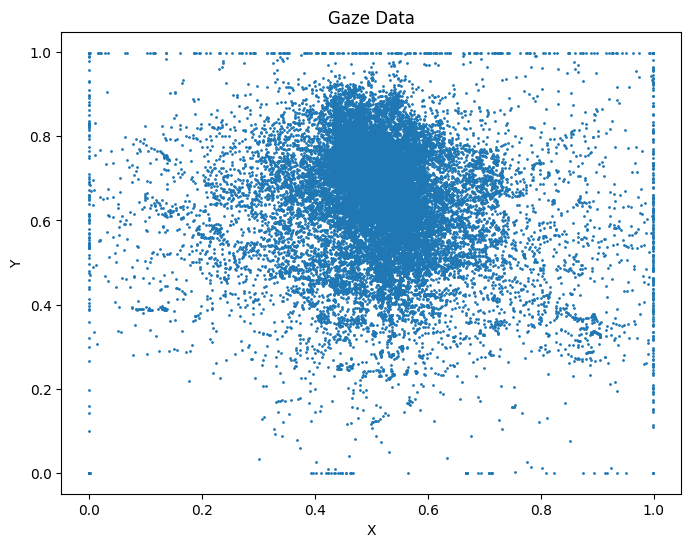

In [13]:
# plot eye gaze data
plt.figure(figsize=(8, 6))
# scatterplot x,y gaze data
plt.scatter(gaze_data[:,0], gaze_data[:,1], s=1)
plt.title('Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [14]:
blink_epsilon = 0.05
# find blinks where x or y is less than epsilon or more than 1-epsilon
blink_indices = np.where(
    (gaze_data[:,0] < blink_epsilon) | (gaze_data[:,0] > 1-blink_epsilon) |
    (gaze_data[:,1] < blink_epsilon) | (gaze_data[:,1] > 1-blink_epsilon)
)[0]

# n many blnks found
print(len(blink_indices), 'blinks found')

3582 blinks found


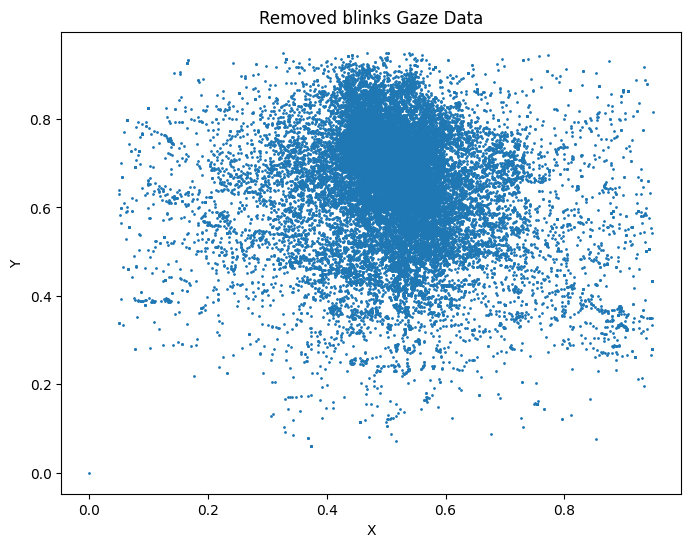

In [15]:
# wherever the blink is, set the gaze point to the last valid gaze point
removed_blinks_gaze_data = gaze_data.copy()
for i in blink_indices:
    removed_blinks_gaze_data[i] = removed_blinks_gaze_data[i-1]

# plot eye gaze data
plt.figure(figsize=(8, 6))
# scatterplot x,y gaze data
plt.scatter(removed_blinks_gaze_data[:,0], removed_blinks_gaze_data[:,1], s=1)
plt.title('Removed blinks Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


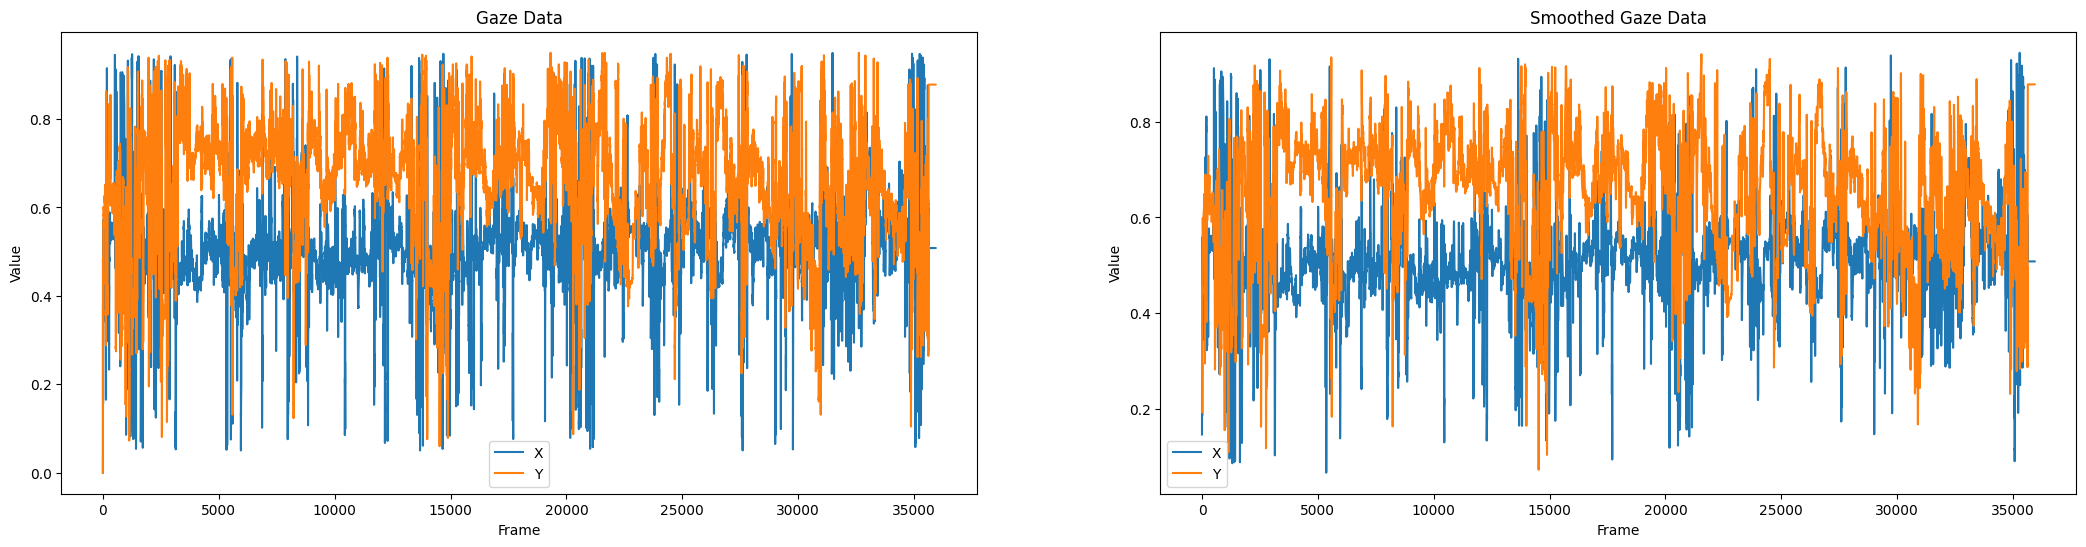

In [16]:
# smooth the first 2 columns of the gaze data
smoothed_gaze_data = removed_blinks_gaze_data.copy()

sigma = 2  # Adjust sigma based on desired smoothness
# Apply Gaussian smoothing to both X and Y coordinates
smoothed_gaze_data[:,0] = gaussian_filter1d(removed_blinks_gaze_data[:,0], sigma=sigma, mode='nearest')
smoothed_gaze_data[:,1] = gaussian_filter1d(removed_blinks_gaze_data[:,1], sigma=sigma, mode='nearest')


# plot eye gaze data
plt.figure(figsize=(26, 6))
# scatterplot x,y gaze data

plt.subplot(1, 2, 1)
plt.plot(removed_blinks_gaze_data[:,0], label='X')
plt.plot(removed_blinks_gaze_data[:,1], label='Y')
plt.title('Gaze Data')
plt.xlabel('Frame')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smoothed_gaze_data[:,0], label='X')
plt.plot(smoothed_gaze_data[:,1], label='Y')
plt.title('Smoothed Gaze Data')
plt.xlabel('Frame')
plt.ylabel('Value')
plt.legend()
plt.show()



# Video processing

In [25]:
file_name = "OP01-R01-PastaSalad"

# Path configurations (unchanged)
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"
out_path = f"../out/{file_name}_noprocessing_5mins.mp4"

stack = 'horizontal' # vertical or horizontal

# Video timing configuration
start_time_sec = 0  # Start at 40 seconds
video_duration_sec = 5*60 # 50 second video output

# Initialize video capture
cap = cv2.VideoCapture(video_path)
actual_fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate frame positions
frame_nr_start = int(start_time_sec * actual_fps)
max_n_frames = int((start_time_sec + video_duration_sec) * actual_fps)

# Ensure we don't exceed video length
if max_n_frames > total_frames:
    max_n_frames = total_frames
    print(f"Warning: Reduced duration to {max_n_frames/actual_fps - start_time_sec:.1f} seconds")

# Video writer setup
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
if stack == 'vertical':
    shape = (frame_width, 3*frame_height)
else:
    shape = (3*frame_width, frame_height)
out = cv2.VideoWriter(out_path, fourcc, actual_fps, shape, isColor=True)

# Set starting position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr_start)

# Main processing loop
current_frame = frame_nr_start
while current_frame < max_n_frames:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get the gaze data for the specific frame
    gaze_point = smoothed_gaze_data[current_frame, :]
    if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
        print(f"Frame {current_frame}: Gaze point out of bounds.")
        continue
    else:
        gaze_x, gaze_y = gaze_point[0], gaze_point[1]

    # crop around gaze point    
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    # to grayscale
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    cropped_tensor = torch.Tensor(cropped).permute(2, 0, 1).float().cuda().unsqueeze(0).detach()

    grayscale_cropped = cropped_tensor.mean(1).unsqueeze(1)
    grayscale_cropped = (grayscale_cropped - grayscale_cropped.min()) / (grayscale_cropped.max() - grayscale_cropped.min())
    response_numpy = grayscale_cropped.squeeze().cpu().detach().numpy()

    # overlay LoG response
    overlayed_response = overlay_image(
        original_frame=frame,
        overlay_image=response_numpy*255,
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_overlay=phosphene_fov
    )

    simulator.reset()
    electrodes = simulator.sample_stimulus(grayscale_cropped.squeeze(0).max(0).values, rescale=True)
    electrodes = modified_cdf_normalization(electrodes, amplitude)
    phosphenes = simulator(electrodes*stim_weights).detach().cpu()

    # overlay phosphenes
    overlayed_phosphenes = overlay_image(
        original_frame=frame,
        overlay_image=phosphenes.cpu().numpy()*255,
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_overlay=phosphene_fov
    )

    # make type uint8
    response_img = overlayed_response
    phosphenes_img = overlayed_phosphenes

    # add red dot for gaze point over frame
    gaze_x_px = int(gaze_x * frame_width)
    gaze_y_px = int(gaze_y * frame_height)
    cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    # stack vertically or horizontally
    if stack == 'vertical':
        axis = 0
    else:
        axis = 1
    cat = np.concatenate([frame, response_img, phosphenes_img], axis=axis).astype('uint8')
    
    # Write the frame
    out.write(cat)
    
    current_frame += 1

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()

In [24]:
file_name = "OP01-R01-PastaSalad"

# Path configurations (unchanged)
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"
out_path = f"../out/{file_name}_shiftvariantLoG_5mins.mp4"

stack = 'horizontal' # vertical or horizontal

# Video timing configuration
start_time_sec = 0  # Start at 40 seconds
video_duration_sec = 5*60 # 50 second video output

# Initialize video capture
cap = cv2.VideoCapture(video_path)
actual_fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate frame positions
frame_nr_start = int(start_time_sec * actual_fps)
max_n_frames = int((start_time_sec + video_duration_sec) * actual_fps)

# Ensure we don't exceed video length
if max_n_frames > total_frames:
    max_n_frames = total_frames
    print(f"Warning: Reduced duration to {max_n_frames/actual_fps - start_time_sec:.1f} seconds")

# Video writer setup
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
if stack == 'vertical':
    shape = (frame_width, 3*frame_height)
else:
    shape = (3*frame_width, frame_height)
out = cv2.VideoWriter(out_path, fourcc, actual_fps, shape, isColor=True)

# Set starting position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr_start)

# Main processing loop
current_frame = frame_nr_start
while current_frame < max_n_frames:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get the gaze data for the specific frame
    gaze_point = smoothed_gaze_data[current_frame, :]
    if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
        print(f"Frame {current_frame}: Gaze point out of bounds.")
        continue
    else:
        gaze_x, gaze_y = gaze_point[0], gaze_point[1]

    # crop around gaze point    
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    # to grayscale
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    cropped_tensor = torch.Tensor(cropped).permute(2, 0, 1).float().cuda().unsqueeze(0).detach()

    # LoG response
    with torch.no_grad():
        response = layer(cropped_tensor).clip(0, None).detach()
    response = (response - response.min()) / (response.max() - response.min())
    response_numpy = response.squeeze().cpu().detach().numpy()

    # overlay LoG response
    overlayed_response = overlay_image(
        original_frame=frame,
        overlay_image=response_numpy.transpose(1,2,0)*255,
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_overlay=phosphene_fov
    )

    simulator.reset()
    electrodes = simulator.sample_stimulus(response.squeeze(0).max(0).values, rescale=True)
    electrodes = modified_cdf_normalization(electrodes, amplitude)
    phosphenes = simulator(electrodes*stim_weights).detach().cpu()

    # overlay phosphenes
    overlayed_phosphenes = overlay_image(
        original_frame=frame,
        overlay_image=phosphenes.cpu().numpy()*255,
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_overlay=phosphene_fov
    )

    # make type uint8
    response_img = overlayed_response
    phosphenes_img = overlayed_phosphenes

    # add red dot for gaze point over frame
    gaze_x_px = int(gaze_x * frame_width)
    gaze_y_px = int(gaze_y * frame_height)
    cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    # stack vertically or horizontally
    if stack == 'vertical':
        axis = 0
    else:
        axis = 1
    cat = np.concatenate([frame, response_img, phosphenes_img], axis=axis).astype('uint8')
    
    # Write the frame
    out.write(cat)
    
    current_frame += 1

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()